# This notebook sets an absorption line, which we will reproduce with forward modeling

Simple proof of concept modeling.

We want to predict the metallicity of a system by assuming that gas is distributed along all of line of sight assuming some radial profile. And from that teasing out the metallicity.

Written By:  Rongmon Bordoloi
             Feb 22, 2019

Tested on: Python 3.7



In [177]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from importlib import reload

from rbvfit import model as m
reload(m)

import emcee
import corner
import scipy.optimize as op
import sys

# Make a first, basic, single component test profile

(0.0, 1.2)

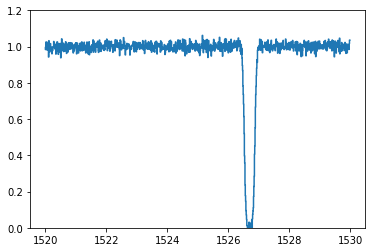

In [178]:
wave=np.arange(1520.,1530.,0.01)
n_clouds = 1
logN=np.array([15.])
b=np.array([20.])
v=np.array([0.])

zabs     = np.zeros((n_clouds))
lambda_rest = 1526.9 * np.ones((n_clouds))

s=m.create_voigt(zabs,lambda_rest)
theta=np.concatenate((logN,b,v))
outflux= s.model_flux(theta,wave)

orig_values = np.array([ logN, b, v ])

# Add error
fnorm= outflux + np.random.normal(0., .02, len(wave))
enorm= 0.02 * np.ones((len(wave),))

plt.step(wave,fnorm)
plt.ylim([0.,1.2])

# Setup Model for line properties

In [220]:
#los=np.arange(-100.,100.,1)
def estimate_parameter_single_cell(log_rho, log_los_cm, log_solar, log_f_c, vel_p, log_temp):
    # Convert the number density to actual ion number density 
    # Set metallicity
    O_H_Solar    = 10.**(-3.31);
    C_H_Solar    = 10.**(-3.61);
    Ne_H_Solar   = 10.**(-4.00);
    N_H_Solar    = 10.**(-4.07);
    Si_H_Solar   = 10.**(-4.46);
    Mg_H_Solar   = 10.**(-4.46);
    
    KBOLTZMANN = 1.3806488e-16;
    
    # Atomic Mass unit, grams.
    AMU          = 1.6605388*10.**(-24.);
    kmpsToCmps   = 1.0*10.**(5.);
    oxygenMass   = 15.999 * AMU;
    carbonMass   =  6.000 * AMU;
    neonMass     = 10.000 * AMU;
    nitrogenMass = 7.000 * AMU;
    silliconMass = 14.00 * AMU;
    magnesiumMass= 12.00 *AMU; 
    
    X_mass= silliconMass
    X_H_Solar= Si_H_Solar

    # Compute b assuming it is thermal at temperature Temp
    b = np.ones_like(log_rho)*(1.0*10.**(-5.)*np.sqrt(2.0 *KBOLTZMANN * 10.0**log_temp / X_mass))

    metallicity = 10.0**(log_solar)*X_H_Solar
    
    # Set ionization fraction, total column density, and log column density
    rho_ion= (10.0**(log_rho) * metallicity * 10.0**(log_f_c) )
    rho_ion= rho_ion + 1e-99   
    col_per_cell=rho_ion*10.0**(log_los_cm)
    logN=np.log10(col_per_cell)
    
    return np.array(logN), np.array(b), np.array(vel_p)



def model_guess(beta,wave):
    log_rho    = np.array([beta[0]])
    log_los_cm = np.array([beta[1]])
    log_solar  = np.array([beta[2]])
    log_f_c    = np.array([beta[3]])
    vel_p      = np.array([beta[4]])
    log_temp   = np.array([beta[5]])
    
    Temp = 10.0**log_temp    #3e4 # Fixed
        
    logN, b, vel_p= estimate_parameter_single_cell(log_rho, log_los_cm, log_solar, log_f_c, vel_p, log_temp)
    #print(beta)
    #print(logN,b,vel_p)
    theta  = np.concatenate((logN,b,vel_p))
    outflux= s.model_flux(theta,wave)
    
    return outflux

# Make a random first guess; Compare with target; bad fit.

12.749555225133086 5.969372813963787 0.0


(0.0, 1.2)

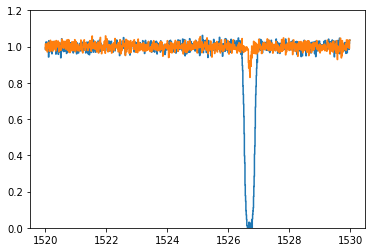

In [223]:
rho = 1e-4           # a semi-typical CGM density
loc_cm = 3.086e+21   # a kpc
solar =1.05
f_c = 0.5
vel_const = 0.
Temp= 3e4

logN_guess, b_guess, vel_p_guess= estimate_parameter_single_cell(np.log10(rho), np.log10(loc_cm), np.log10(solar), np.log10(f_c), vel_const, np.log10(Temp))
    
print(logN_guess, b_guess, vel_p_guess)

theta=np.concatenate(([logN_guess],[b_guess],[vel_p_guess]))
outflux_guess= s.model_flux(theta,wave)

# Add error
fnorm_guess= outflux_guess + np.random.normal(0., .02, len(wave))
enorm_guess= 0.02 * np.ones((len(wave),))

plt.step(wave,fnorm)
plt.step(wave,fnorm_guess)
plt.ylim([0.,1.2])

# Setup Likelihoods

In [224]:
######## Computing Likelihoods######
def lnprior(theta, lb, ub):
    for index in range(0, len(lb)):
        if (lb[index] > theta[index]) or (ub[index] < theta[index]):
            #print("index,Lower,Upper,Actual")
            #print(index,lb[index],ub[index],theta[index])
            return -np.inf
            break
    return 0.0

def lnlike(theta, model, x, y, yerr):
    model_y = model(theta, x)
#    inv_sigma2 = 1.0 / (yerr ** 2)
    inv_sigma2 = 1.0/(yerr**2 + model_y**2*np.exp(2*theta[-1]))
    return -0.5 * (np.sum((y - model_y) ** 2 * inv_sigma2 - np.log(inv_sigma2) ))

def lnprob(theta, lb, ub, model, x, y, yerr):
    lp = lnprior(theta, lb, ub)
    if not np.isfinite(lp):
        #print('prior violation...')
        return -np.inf
    return lp + lnlike(theta, model, x, y, yerr)

def optimize_guess(model, theta, lb, ub, x, y, yerr):
    nll = lambda *args: -lnprob(*args)
    result = op.minimize(nll, [theta], args=(lb, ub, model, x, y, yerr))
    p = result["x"]
    return p

Current Starting Position
13.749555225133086 18.876814294814142 0.0
Input values were (logN,b,v):
[15. 20.  0.]
Optimizing Guess ***********
[-3.00000000e+00  2.14893959e+01  2.11892991e-02 -3.01029996e-01
  0.00000000e+00  5.47712125e+00  1.00000000e-05]


(0.0, 1.2)

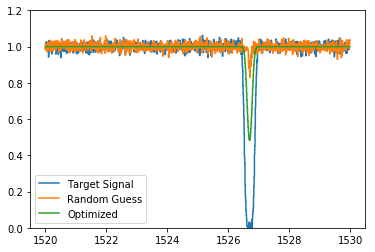

In [229]:
rho    = 1e-3           # a semi-typical CGM density
loc_cm = 3.086e+21      # a kpc
solar  =1.05
f_c    = 0.5
vel_const = 0.
temp   =3e5


beta = [np.log10(rho), np.log10(loc_cm), np.log10(solar), np.log10(f_c), vel_const, np.log10(temp),  1e-5]
lb   = [-10, 10, -4, -1, -500., 1, -np.inf]
ub   = [2  , 25,  1,  0,  500., 9,  0.0   ]

logN_, b_, vel_p_= estimate_parameter_single_cell(beta[0], beta[1], beta[2], beta[3], beta[4], beta[5])

print("Current Starting Position")
print(logN_, b_, vel_p_)
print("Input values were (logN,b,v):")
print(orig_values.flatten())
#[ 0.14122014 22.17361361  0.1615893  -0.41391099 -0.32890792]


print('Optimizing Guess ***********')
popt = optimize_guess(model_guess, beta, lb, ub, wave, fnorm, enorm)
print(popt)

outflux_opt_guess= model_guess( popt, wave)

# Add error
fnorm_opt_guess= outflux_opt_guess #+ np.random.normal(0., .02, len(wave))
enorm_opt_guess= 0.02 * np.ones((len(wave),))

plt.step(wave,fnorm, label='Target Signal')
plt.step(wave,fnorm_guess, label='Random Guess')
plt.step(wave,fnorm_opt_guess, label='Optimized')
plt.legend()
plt.ylim([0.,1.2])



# Do it.

In [230]:
perturbation=1e-1
no_of_Chain=50
no_of_steps=5000

length_of_lb = len(lb)
ndim, nwalkers = length_of_lb, no_of_Chain


# guesses are optimized guess from above plus random perturbations 
guesses = [popt + perturbation * np.random.randn(ndim) for i in range(nwalkers)]
print("Starting emcee ***********")
burntime = np.round(no_of_steps * .2)
print(burntime)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, threads=8, args=(lb, ub, model_guess, wave, fnorm, enorm))
print("Start Burntime Calculations ***********")



import sys
width = 30
#First Burning some steps
pos, prob, state = sampler.run_mcmc(guesses, burntime)
sampler.reset()


print("Done Burning Steps!")
print("Now starting the Final Calculations:")
InitialState = np.median(samples,axis=0)
print(InitialState)
print("*****************")
#Now Running mcmc
for i, result in enumerate(sampler.sample(pos, iterations=no_of_steps)):
    n = int((width+1) * float(i) / no_of_steps)
    sys.stdout.write("\r[{0}{1}]".format('#' * n, ' ' * (width - n)))
    #print(sampler.chain.shape)
    #print(sampler.chain[0,-1,:])
    #print(InitialState - np.median(samples,axis=0))
sys.stdout.write("\n")

Starting emcee ***********
1000.0
Start Burntime Calculations ***********


/Users/paultorrey/anaconda3/envs/py37/lib/python3.7/site-packages/emcee-3.0rc2-py3.7.egg/emcee/moves/red_blue.py:97: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done Burning Steps!
Now starting the Final Calculations:
[-4.04547799 17.98004301 -1.42679201 -0.50474235 -3.05418986 -0.022418  ]
*****************
[##############################]


# Plot it.

(200000, 7)
(7,)
Input values were (logN,b,v):
[15. 20.  0.]
Derived values are:
(array(15.41157302), array(20.37178952), array(0.0692982))


(0.0, 1.2)

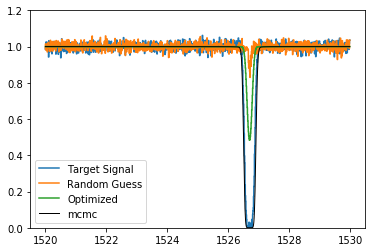

In [232]:
samples=sampler.chain[:, np.rint(no_of_steps/5).astype(np.int):, :].reshape((-1, ndim))#sampler.flatchain
st=np.median(samples,axis=0)#np.median(sampler.flatchain, axis=0)
print(samples.shape)
print(st.shape)
#df = pd.DataFrame(samples)
#temp=df.mode()
#st=temp.values[0]

theta_prime=st[:-1]

print("Input values were (logN,b,v):")
print(orig_values.flatten())
print("Derived values are:")
print(estimate_parameter_single_cell(*theta_prime))




best_fit = model_guess(theta_prime,wave)

plt.step(wave,fnorm, label='Target Signal')
plt.step(wave,fnorm_guess, label='Random Guess')
plt.step(wave,fnorm_opt_guess, label='Optimized')
plt.plot(wave,best_fit,color='k',linewidth=1,label='mcmc')

plt.legend()
plt.ylim([0.,1.2])


#plt.step(wave,fnorm,linewidth=0.5)
#plt.step(wave,enorm,color='r',linewidth=0.5)

## Plot random solutions
#index=np.random.randint(0,high=len(samples), size=100)
#for i in range(len(index)):
#	plt.plot(wave,model_guess(samples[index[i],:],wave),color="k", alpha=0.1)

#plt.xlim([-500,1200])
#plt.ylim([0,1.5])








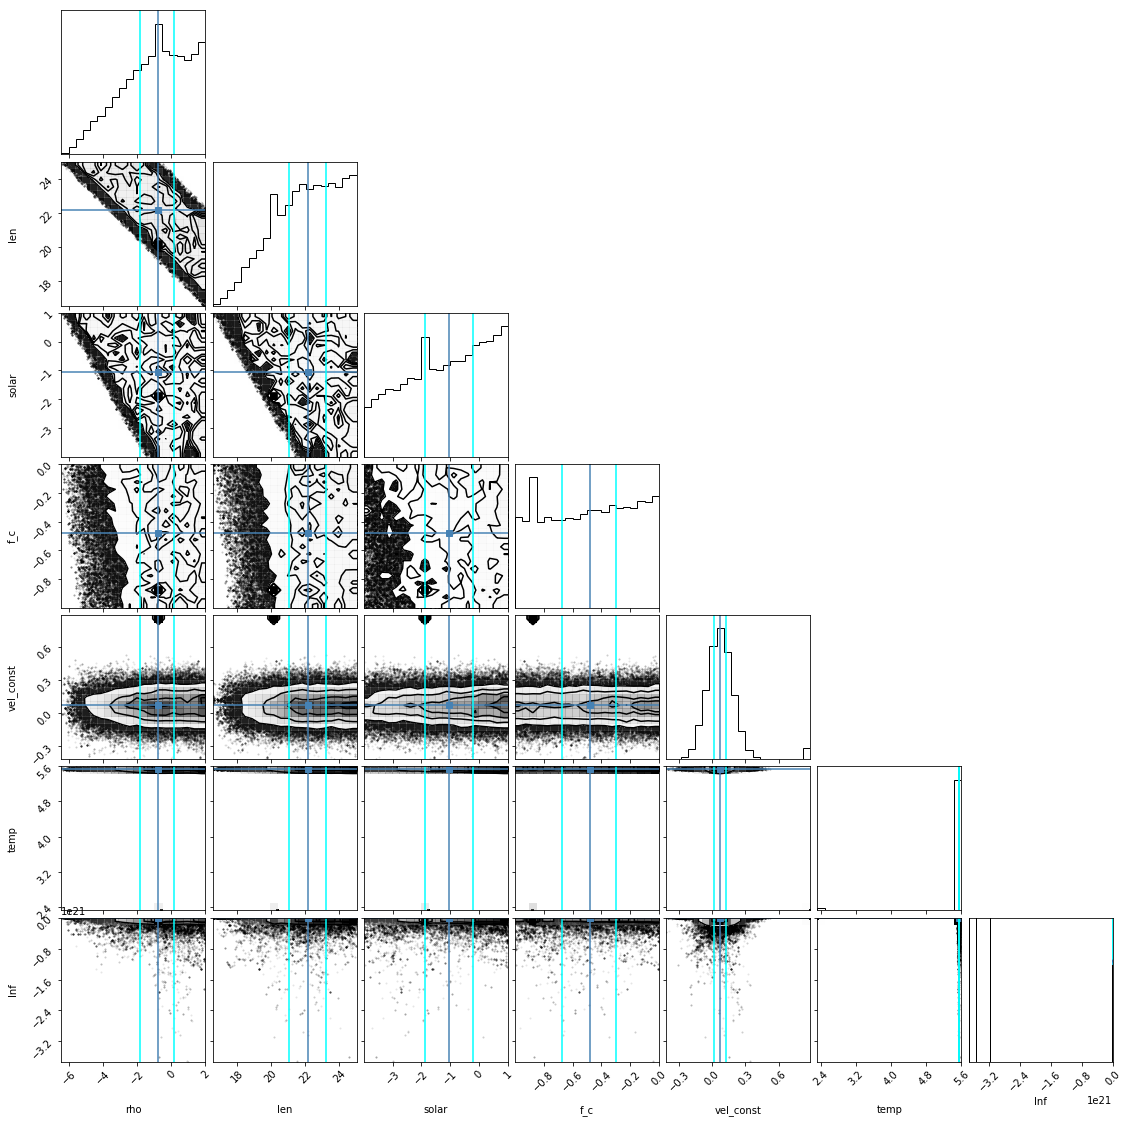

In [234]:
samples=sampler.chain[:, 100:, :].reshape((-1, ndim))#sampler.flatchain
st=np.median(samples,axis=0)#np.median(sampler.flatchain, axis=0)
#df = pd.DataFrame(samples)
#temp=df.mode()
#st=temp.values[0]


text_label=['rho', 'len', 'solar', 'f_c', 'vel_const', 'temp', 'lnf']
figure=corner.corner(samples, labels=text_label, truths=st)
theta_prime=st


value1 =np.percentile(samples,32,axis=0)

# This is the empirical mean of the sample:
value2 = np.percentile(samples,68,axis=0)
# Extract the axes
axes = np.array(figure.axes).reshape((ndim, ndim))

# Loop over the diagonal
for i in range(ndim):
    ax = axes[i, i]
    ax.axvline(value1[i], color="aqua")
    ax.axvline(value2[i], color="aqua")

# Loop over the histograms
for yi in range(ndim):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline(value1[xi],color="aqua")
        ax.axvline(value2[xi],color="aqua")
        #ax.axhline(value1[yi], color="g")
        #ax.axhline(value2[yi], color="r")
        #ax.plot(value1[xi], value1[yi], "sg")
        #ax.plot(value2[xi], value2[yi], "sr")
        

best_fit = model_guess(theta_prime,wave)

plt.step(wave,fnorm,linewidth=0.5)
plt.step(wave,enorm,color='r',linewidth=0.5)

## Plot random solutions
index=np.random.randint(0,high=len(samples), size=100)
for i in range(len(index)):
	plt.plot(wave,model_guess(samples[index[i],:],wave),color="k", alpha=0.1)

#plt.xlim([-500,1200])
plt.ylim([0,1.5])
plt.plot(wave,best_fit,color='r',linewidth=1)



## Now try something just a bit more complicated.  Multiple line components.

(0.0, 1.2)

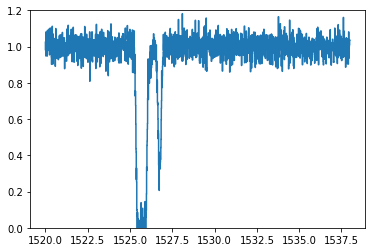

In [238]:
wave=np.arange(1520.,1538.,0.01)
# We are setting up 3 clumps at z = 0
# For SiII 1526 absorption
# With default 6.5 pixel FWHM of HST/COS and Gaussian convolution
n_clouds = 3
zabs=np.zeros((n_clouds))
lambda_rest = 1526.9 * np.ones((n_clouds))
s=m.create_voigt(zabs,lambda_rest)

#Properties of the lines (column density, dopler b, velocity)
logN=np.array([14.,13., 16.])
b=np.array([20.,21.,29.])
v=np.array([10.,-100.,-200.])
theta=np.concatenate((N,b,v))

outflux= s.model_flux(theta,wave)
orig_values = np.array([logN, b, v])

# Add error
fnorm= outflux + np.random.normal(0., .05, len(wave))
enorm= 0.02 * np.ones((len(wave),))

plt.step(wave,fnorm)
plt.ylim([0.,1.2])

Current Starting Position
13.749555225133086 18.876814294814142 0.0
Input values were (logN,b,v):
[  14.   13.   16.   20.   21.   29.   10. -100. -200.]
Optimizing Guess ***********
[-3.00000000e+00  2.14893959e+01  2.11892991e-02 -3.01029996e-01
  0.00000000e+00  5.47712125e+00  1.00000000e-05]


(0.0, 1.2)

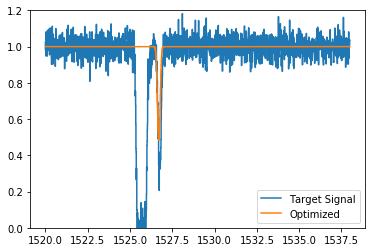

In [240]:
rho    = 1e-3           # a semi-typical CGM density
loc_cm = 3.086e+21      # a kpc
solar  =1.05
f_c    = 0.5
vel_const = 0.
temp   =3e5


beta = [np.log10(rho), np.log10(loc_cm), np.log10(solar), np.log10(f_c), vel_const, np.log10(temp),  1e-5]
lb   = [-10, 10, -4, -1, -500., 1, -np.inf]
ub   = [2  , 25,  1,  0,  500., 9,  0.0   ]

logN_, b_, vel_p_= estimate_parameter_single_cell(beta[0], beta[1], beta[2], beta[3], beta[4], beta[5])

print("Current Starting Position")
print(logN_, b_, vel_p_)
print("Input values were (logN,b,v):")
print(orig_values.flatten())
#[ 0.14122014 22.17361361  0.1615893  -0.41391099 -0.32890792]


print('Optimizing Guess ***********')
popt = optimize_guess(model_guess, beta, lb, ub, wave, fnorm, enorm)
print(popt)

outflux_opt_guess= model_guess( popt, wave)

# Add error
fnorm_opt_guess= outflux_opt_guess #+ np.random.normal(0., .02, len(wave))
enorm_opt_guess= 0.02 * np.ones((len(wave),))

plt.step(wave,fnorm, label='Target Signal')
#plt.step(wave,fnorm_guess, label='Random Guess')
plt.step(wave,fnorm_opt_guess, label='Optimized')
plt.legend()
plt.ylim([0.,1.2])

In [241]:
perturbation=1e-1
no_of_Chain=50
no_of_steps=5000

length_of_lb = len(lb)
ndim, nwalkers = length_of_lb, no_of_Chain


# guesses are optimized guess from above plus random perturbations 
guesses = [popt + perturbation * np.random.randn(ndim) for i in range(nwalkers)]
print("Starting emcee ***********")
burntime = np.round(no_of_steps * .2)
print(burntime)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, threads=8, args=(lb, ub, model_guess, wave, fnorm, enorm))
print("Start Burntime Calculations ***********")



import sys
width = 30
#First Burning some steps
pos, prob, state = sampler.run_mcmc(guesses, burntime)
sampler.reset()


print("Done Burning Steps!")
print("Now starting the Final Calculations:")
InitialState = np.median(samples,axis=0)
print(InitialState)
print("*****************")
#Now Running mcmc
for i, result in enumerate(sampler.sample(pos, iterations=no_of_steps)):
    n = int((width+1) * float(i) / no_of_steps)
    sys.stdout.write("\r[{0}{1}]".format('#' * n, ' ' * (width - n)))
    #print(sampler.chain.shape)
    #print(sampler.chain[0,-1,:])
    #print(InitialState - np.median(samples,axis=0))
sys.stdout.write("\n")

Starting emcee ***********
1000.0
Start Burntime Calculations ***********
Done Burning Steps!
Now starting the Final Calculations:
[-7.55856161e-01  2.21547554e+01 -1.04236168e+00 -4.77916053e-01
  6.93697998e-02  5.54349929e+00 -4.28411638e+11]
*****************
[##############################]


(200000, 7)
(7,)
Input values were (logN,b,v):
[  14.   13.   16.   20.   21.   29.   10. -100. -200.]
Derived values are:
(array(14.03748639), array(22.11746), array(9.97852057))


(0.0, 1.2)

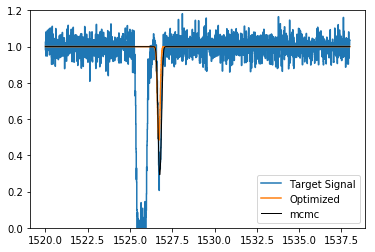

In [243]:
samples=sampler.chain[:, np.rint(no_of_steps/5).astype(np.int):, :].reshape((-1, ndim))#sampler.flatchain
st=np.median(samples,axis=0)#np.median(sampler.flatchain, axis=0)
print(samples.shape)
print(st.shape)
#df = pd.DataFrame(samples)
#temp=df.mode()
#st=temp.values[0]

theta_prime=st[:-1]

print("Input values were (logN,b,v):")
print(orig_values.flatten())
print("Derived values are:")
print(estimate_parameter_single_cell(*theta_prime))




best_fit = model_guess(theta_prime,wave)

plt.step(wave,fnorm, label='Target Signal')
#plt.step(wave,fnorm_guess, label='Random Guess')
plt.step(wave,fnorm_opt_guess, label='Optimized')
plt.plot(wave,best_fit,color='k',linewidth=1,label='mcmc')

plt.legend()
plt.ylim([0.,1.2])

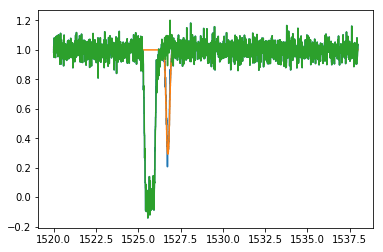

In [252]:
fnorm_2 = fnorm - best_fit + 1.0
plt.step(wave,fnorm)
plt.step(wave,best_fit)
plt.plot(wave,fnorm_2)

Current Starting Position
13.749555225133086 18.876814294814142 0.0
Input values were (logN,b,v):
[  14.   13.   16.   20.   21.   29.   10. -100. -200.]
Optimizing Guess ***********
[-3.00000000e+00  2.14893959e+01  2.11892991e-02 -3.01029996e-01
  0.00000000e+00  5.47712125e+00  1.00000000e-05]


(0.0, 1.2)

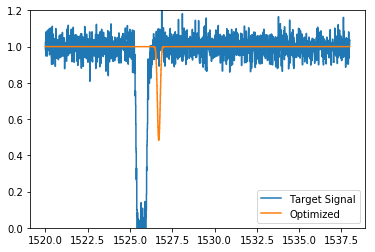

In [253]:
rho    = 1e-3           # a semi-typical CGM density
loc_cm = 3.086e+21      # a kpc
solar  =1.05
f_c    = 0.5
vel_const = 0.
temp   =3e5


beta = [np.log10(rho), np.log10(loc_cm), np.log10(solar), np.log10(f_c), vel_const, np.log10(temp),  1e-5]
lb   = [-10, 10, -4, -1, -500., 1, -np.inf]
ub   = [2  , 25,  1,  0,  500., 9,  0.0   ]

logN_, b_, vel_p_= estimate_parameter_single_cell(beta[0], beta[1], beta[2], beta[3], beta[4], beta[5])

print("Current Starting Position")
print(logN_, b_, vel_p_)
print("Input values were (logN,b,v):")
print(orig_values.flatten())
#[ 0.14122014 22.17361361  0.1615893  -0.41391099 -0.32890792]


print('Optimizing Guess ***********')
popt = optimize_guess(model_guess, beta, lb, ub, wave, fnorm_2, enorm)
print(popt)

outflux_opt_guess= model_guess( popt, wave)

# Add error
fnorm_opt_guess= outflux_opt_guess #+ np.random.normal(0., .02, len(wave))
enorm_opt_guess= 0.02 * np.ones((len(wave),))

plt.step(wave,fnorm_2, label='Target Signal')
#plt.step(wave,fnorm_guess, label='Random Guess')
plt.step(wave,fnorm_opt_guess, label='Optimized')
plt.legend()
plt.ylim([0.,1.2])

In [255]:
perturbation=1e-1
no_of_Chain=50
no_of_steps=5000

length_of_lb = len(lb)
ndim, nwalkers = length_of_lb, no_of_Chain


# guesses are optimized guess from above plus random perturbations 
guesses = [popt + perturbation * np.random.randn(ndim) for i in range(nwalkers)]
print("Starting emcee ***********")
burntime = np.round(no_of_steps * .2)
print(burntime)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, threads=8, args=(lb, ub, model_guess, wave, fnorm_2, enorm))
print("Start Burntime Calculations ***********")



import sys
width = 30
#First Burning some steps
pos, prob, state = sampler.run_mcmc(guesses, burntime)
sampler.reset()


print("Done Burning Steps!")
print("Now starting the Final Calculations:")
InitialState = np.median(samples,axis=0)
print(InitialState)
print("*****************")
#Now Running mcmc
for i, result in enumerate(sampler.sample(pos, iterations=no_of_steps)):
    n = int((width+1) * float(i) / no_of_steps)
    sys.stdout.write("\r[{0}{1}]".format('#' * n, ' ' * (width - n)))
    #print(sampler.chain.shape)
    #print(sampler.chain[0,-1,:])
    #print(InitialState - np.median(samples,axis=0))
sys.stdout.write("\n")

Starting emcee ***********
1000.0
Start Burntime Calculations ***********
Done Burning Steps!
Now starting the Final Calculations:
[-1.54146182 21.64081284 -1.11158734 -0.49027729  9.97852057  5.61473435
 -1.6495763 ]
*****************
[##############################]


(200000, 7)
(7,)
Input values were (logN,b,v):
[  14.   13.   16.   20.   21.   29.   10. -100. -200.]
Derived values are:
(array(15.89052042), array(30.36213643), array(-199.56306293))


(0.0, 1.2)

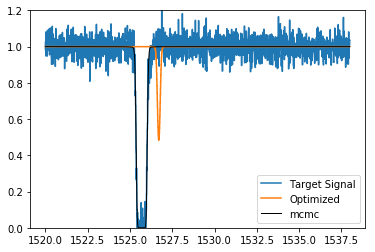

In [256]:
samples=sampler.chain[:, np.rint(no_of_steps/5).astype(np.int):, :].reshape((-1, ndim))#sampler.flatchain
st=np.median(samples,axis=0)#np.median(sampler.flatchain, axis=0)
print(samples.shape)
print(st.shape)
#df = pd.DataFrame(samples)
#temp=df.mode()
#st=temp.values[0]

theta_prime=st[:-1]

print("Input values were (logN,b,v):")
print(orig_values.flatten())
print("Derived values are:")
print(estimate_parameter_single_cell(*theta_prime))




best_fit = model_guess(theta_prime,wave)

plt.step(wave,fnorm_2, label='Target Signal')
#plt.step(wave,fnorm_guess, label='Random Guess')
plt.step(wave,fnorm_opt_guess, label='Optimized')
plt.plot(wave,best_fit,color='k',linewidth=1,label='mcmc')

plt.legend()
plt.ylim([0.,1.2])